In [4]:
import numpy as np
import pandas as pd
import time
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 250)
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import causalinference
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression as lr
from sklearn.ensemble.forest import RandomForestRegressor as rfr
from sklearn.ensemble.forest import RandomForestClassifier as rfc
from sklearn.svm import SVC as svc
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import LocalOutlierFactor as lof
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import metrics

In [5]:
%run ./utils.ipynb

## Load data and preprocess

In [6]:
raw_data_path = 'raw_data.tsv'
raw_data = pd.read_csv(raw_data_path, sep='\t')

In [7]:
data = preprocess(raw_data)
data = data.rename(columns={"IAQ_51C": "T", "IAQ_1CALC": "Y"})
data[['T', 'Y']] = data[['T', 'Y']].astype(np.int64)
data = data[(data['T'] != -1) & (data['Y'] != -1)]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2494 entries, 0 to 2612
Data columns (total 33 columns):
CASEID         2494 non-null int64
AGECALC        2494 non-null int64
IAQ_17CM       2494 non-null float64
IAQ_15KG       2494 non-null float64
RACEUP         2494 non-null int64
IAQ_35         2494 non-null float64
IAQ_41         2494 non-null float64
MARITAL1       2494 non-null int64
EMPL1          2494 non-null int64
IAQ_42         2494 non-null float64
INCOME         2494 non-null float64
T              2494 non-null int64
IAQ_18A        2494 non-null int64
IAQ_18B        2494 non-null int64
IAQ_18C        2494 non-null int64
IAQ_18D        2494 non-null int64
IAQ_23         2494 non-null float64
IAQ_25         2494 non-null int64
IAQ_26         2494 non-null float64
IQ27KG_LAST    2494 non-null float64
IQ29_LAST      2494 non-null int64
Y              2494 non-null int64
IAQ_19A        2494 non-null int64
IAQ_19B        2494 non-null int64
IAQ_19C        2494 non-null int64


# Feature correlation

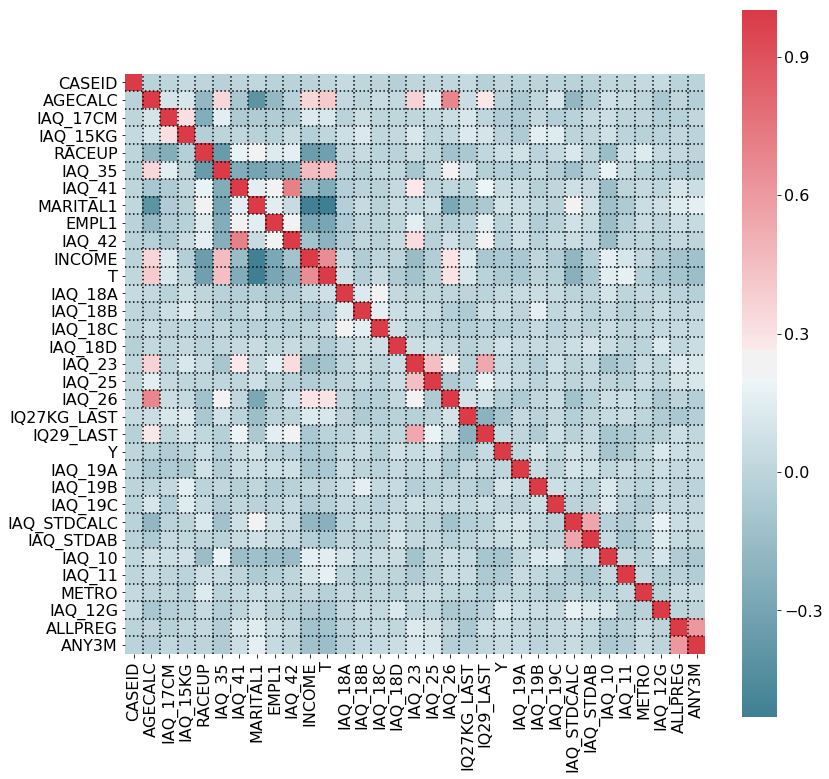

In [5]:
f, ax = plt.subplots(figsize=(13, 13))
# corr = data.loc[:, 'INCOME_2.0':'INCOME_16.0'].corr()
corr = data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax)
ax.hlines([i for i in range(1, data.shape[1])], *ax.get_xlim(), linestyles='dotted')
ax.vlines([i for i in range(1, data.shape[1])], *ax.get_ylim(), linestyles='dotted')

# Feature Overlap

C:\Users\Tom\Miniconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


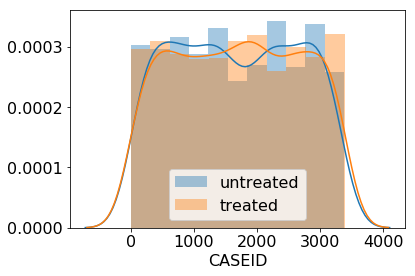

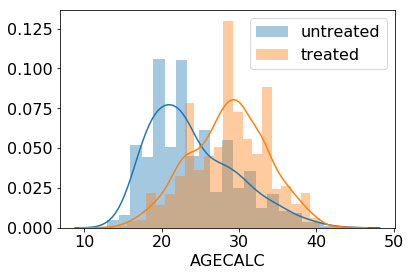

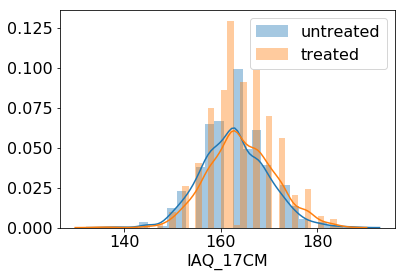

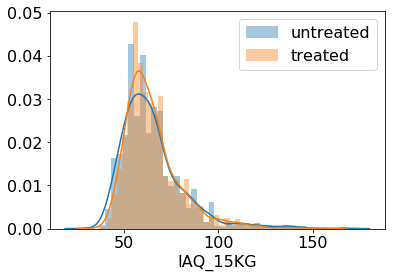

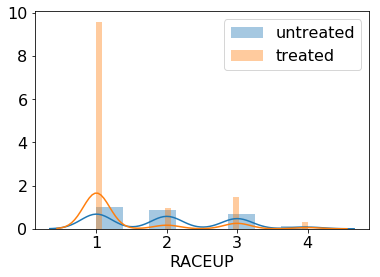

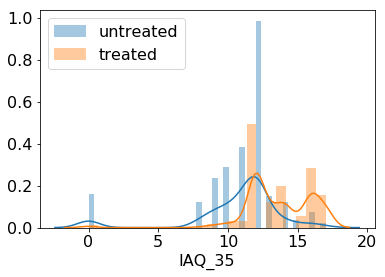

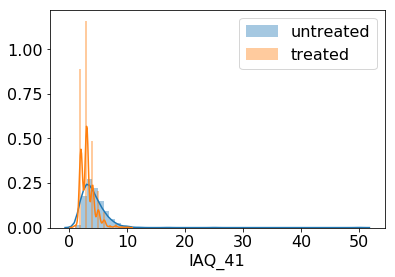

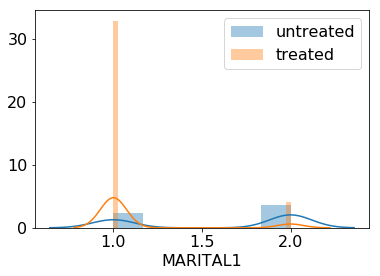

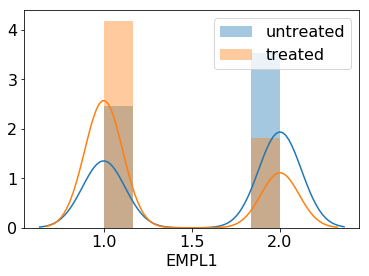

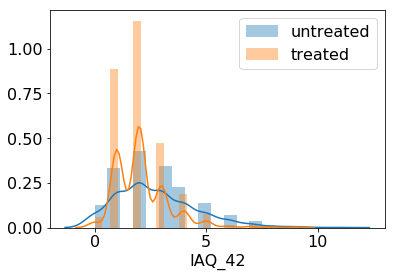

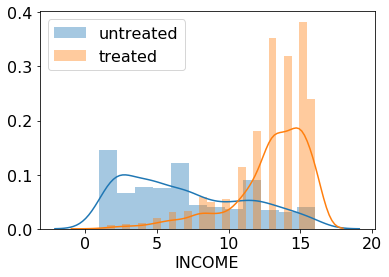

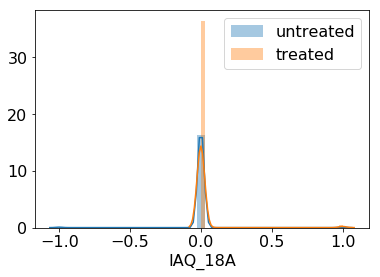

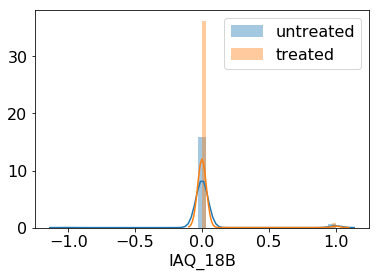

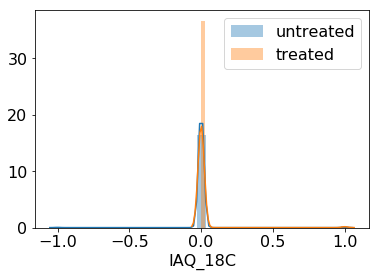

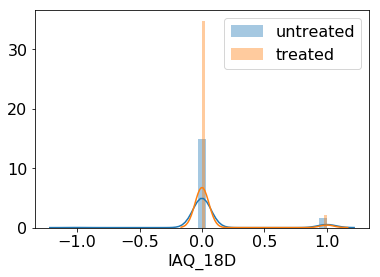

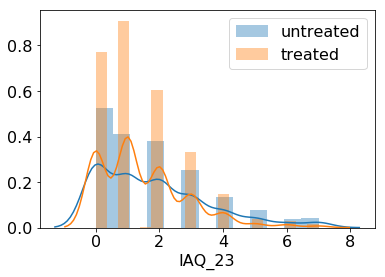

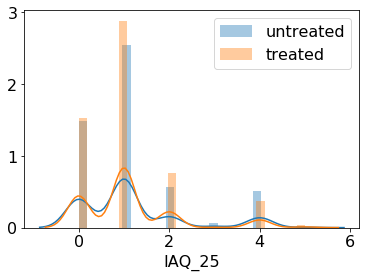

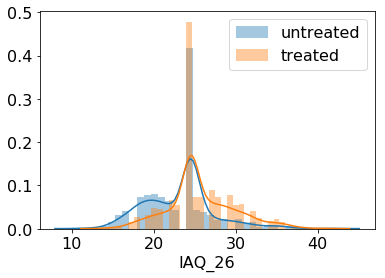

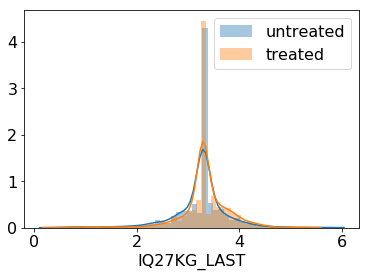

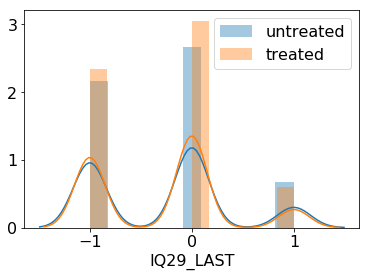

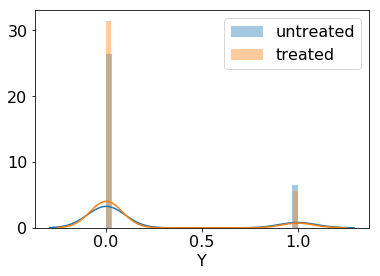

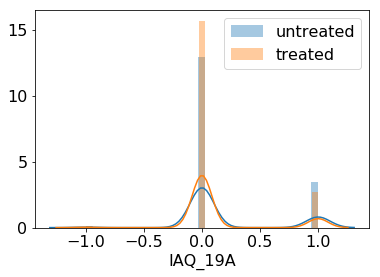

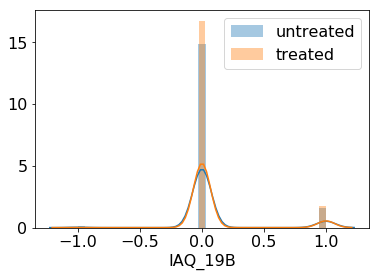

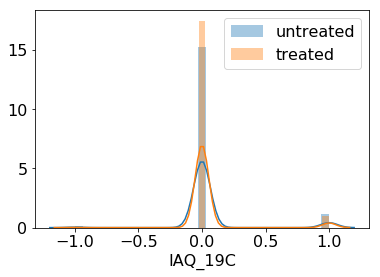

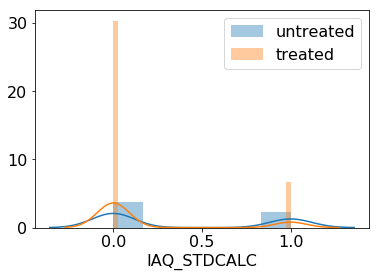

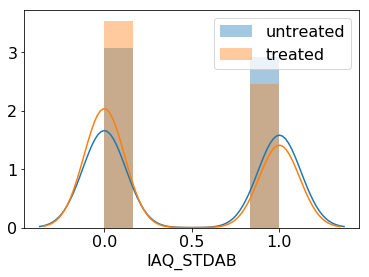

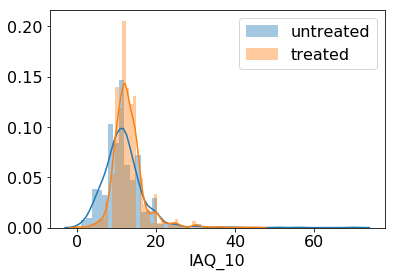

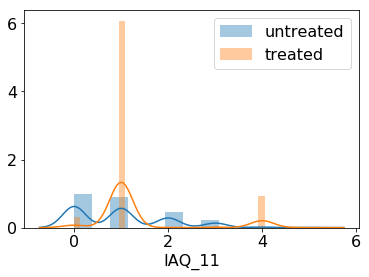

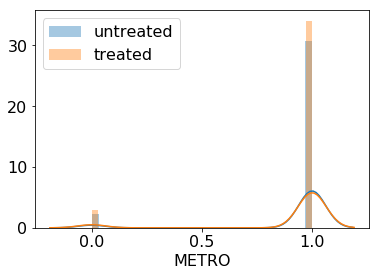

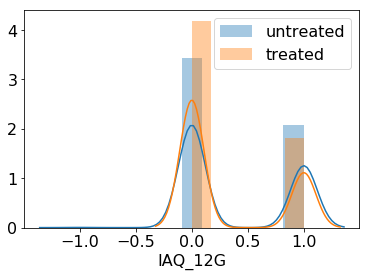

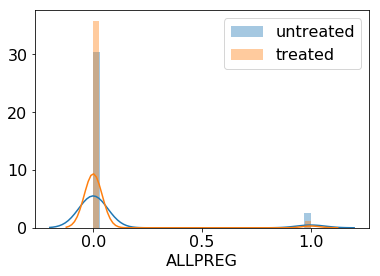

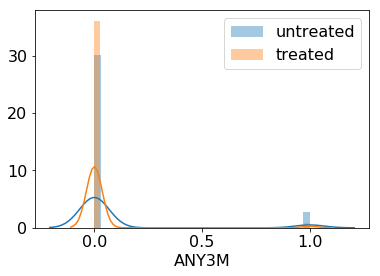

In [6]:
for i, col in enumerate(data.columns):
    if col != 'T':
        plt.figure(i)
        sns.distplot(data[data['T'] == 0][col], label="untreated", norm_hist=True)
        sns.distplot(data[data['T'] == 1][col], label="treated", norm_hist=True)
        plt.legend()

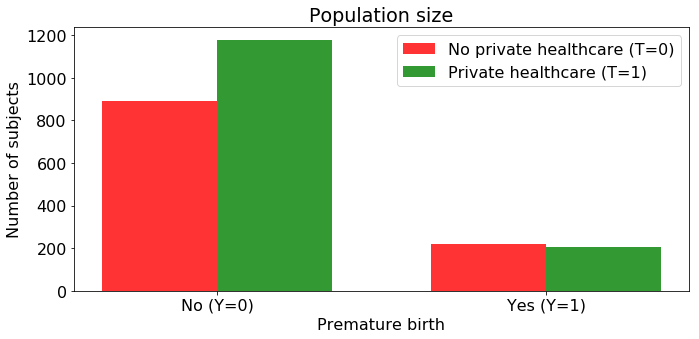

In [117]:
n_groups = 2
t_0 = (data[(data['Y']==0) & ((data['T']==0))].shape[0], data[(data['Y']==1) & ((data['T']==0))].shape[0])
t_1 = (data[(data['Y']==0) & ((data['T']==1))].shape[0], data[(data['Y']==1) & ((data['T']==1))].shape[0])
 
# create plot
fig, ax = plt.subplots(figsize=(10, 5))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, t_0, bar_width,
alpha=opacity,
color='r',
label='No private healthcare (T=0)')
 
rects2 = plt.bar(index + bar_width, t_1, bar_width,
alpha=opacity,
color='g',
label='Private healthcare (T=1)')
 
plt.xlabel('Premature birth')
plt.ylabel('Number of subjects')
plt.title('Population size')
plt.xticks(index + bar_width/2, ('No (Y=0)', 'Yes (Y=1)'))
plt.legend()
 
plt.tight_layout()
plt.show()

## Propensity Estimation

In [5]:
Y = data['T'].copy()
X = data.drop(['T', 'Y'], axis=1).copy()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

lr_model = lr(solver='lbfgs', C=0.0025, multi_class='multinomial', max_iter=5000)

model_results(lr_model, X, Y, cv=True)

lr_model.fit(X, Y)

Model Results:
Avg. Accuracy: 0.843 , std: +/- 0.027
Avg. F1: 0.862 , std: +/- 0.024
Avg. ROC AUC: 0.918 , std: +/- 0.018


LogisticRegression(C=0.0025, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=5000,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)

In [42]:
prop_data = data.copy()
prop_data['propensity'] = lr_model.predict_proba(X)[:,1]

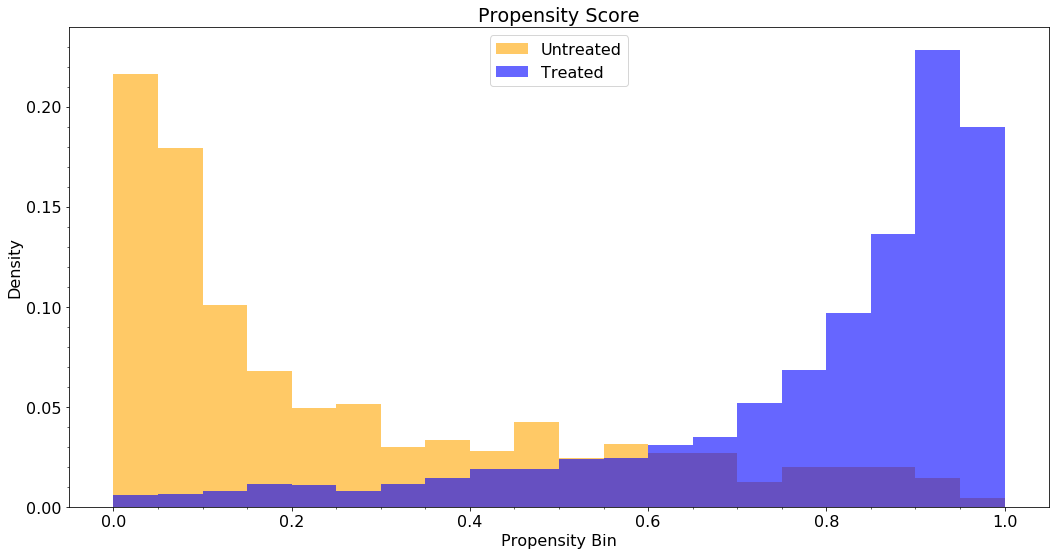

In [43]:
plot_propensity(prop_data, 20)

## Odds Ratio calculations

In [44]:
calc_odds_ratio(prop_data, 'T', 'Y', 'crude')

(0.0434856508810762,
 (0.03529066695567048, 0.0535836241045311),
 (207.0, 1178.0, 889.0, 220.0))

In [45]:
calc_odds_ratio(prop_data, 'T', 'Y', 'ipw')

(0.999860858514292,
 (0.8585022398886134, 1.1644951986597567),
 (417.1478710768134,
  385.82872455387167,
  1965.4966259472694,
  1817.6756771862752))

In [52]:
calc_odds_ratio(prop_data, 'T', 'Y', 'stratified')

[0.0, 0.11362891659540192, 0.4665779837458846, 0.790817256254007, 0.918781246345628, 1.0]


(0.9536137659409749,
 (1.4224994735200838, 0.6392826370204553),
 [(4.0, 100.0, 16.0, 379.0),
  (25.0, 76.0, 96.0, 302.0),
  (53.0, 35.0, 265.0, 145.0),
  (62.0, 7.0, 380.0, 50.0),
  (63.0, 2.0, 421.0, 13.0)])

In [40]:
# Trim propensity by threshold
t = 0.05

In [36]:
calc_odds_ratio(prop_data[(prop_data['propensity'] >= t) & (prop_data['propensity'] < 1-t)], 'T', 'Y', 'crude')

(0.04300811010076186,
 (0.03400066113157547, 0.05440181081424598),
 (175.0, 939.0, 702.0, 162.0))

In [37]:
calc_odds_ratio(prop_data[(prop_data['propensity'] >= t) & (prop_data['propensity'] < 1-t)], 'T', 'Y', 'ipw')

(1.0775996351844002,
 (0.908058477854517, 1.278795366233666),
 (329.6312152416668,
  305.8931868096771,
  1509.2987076152367,
  1509.2949130675438))

In [39]:
calc_odds_ratio(prop_data[(prop_data['propensity'] >= t) & (prop_data['propensity'] < 1-t)], 'T', 'Y', 'stratified')

(1.0604264640326808,
 (0.71049761135809, 1.5826996004552445),
 [(8.0, 75.0, 24.0, 289.0),
  (23.0, 50.0, 94.0, 228.0),
  (43.0, 28.0, 208.0, 117.0),
  (47.0, 7.0, 292.0, 49.0),
  (54.0, 2.0, 321.0, 19.0)])

## T-Learner

In [40]:
X_0 = data[data['T'] == 0].copy()
Y_0 = X_0['Y']
X_0 = X_0.drop(['Y', 'T'], axis = 1)

X_1 = data[data['T'] == 1].copy()
Y_1 = X_1['Y']
X_1 = X_1.drop(['Y', 'T'], axis = 1)

In [50]:
# Single Logistic Regression model

random_state = 10
X_0_train, X_0_test, Y_0_train, Y_0_test = train_test_split(X_0, Y_0, test_size=0.25, random_state=random_state)
print(X_0_train.shape[0], X_0_test.shape[0])
sm = SMOTE(random_state=random_state, ratio = 0.75)

X_0_train, Y_0_train = sm.fit_sample(X_0_train, Y_0_train)

X_1_train, X_1_test, Y_1_train, Y_1_test = train_test_split(X_1, Y_1, test_size=0.25, random_state=random_state)
print(X_1_train.shape[0], X_1_test.shape[0])

sm = SMOTE(random_state=random_state, ratio = 0.75)

X_1_train, Y_1_train = sm.fit_sample(X_1_train, Y_1_train)

f0 = lr(solver='lbfgs', max_iter=1e5)
f1 = lr(solver='lbfgs', max_iter=1e5)

# f0 = rfc(n_estimators=50)
# f1 = rfc(n_estimators=50)

# f0.fit(X_0, Y_0)
# f1.fit(X_1, Y)

# print('*** f0 model ***')
# model_results(f0, X_0_test, Y_0_test, cv=True)
# print('*** f1 model ***')
# model_results(f1, X_1_test, Y_1_test, cv=True)

print(X_0.shape[0], X_1.shape[0])

print('*** f0 model ***')
model_results(f0, X_0, Y_0, cv=True)
print('*** f1 model ***')
model_results(f1, X_1, Y_1, cv=True)

831 278
1038 347
1109 1385
*** f0 model ***
Model Results:
Avg. Accuracy: 0.803 , std: +/- 0.012


C:\Users\Tom\Miniconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Avg. F1: 0.119 , std: +/- 0.063
Avg. ROC AUC: 0.659 , std: +/- 0.058
*** f1 model ***
Model Results:
Avg. Accuracy: 0.848 , std: +/- 0.007


C:\Users\Tom\Miniconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Tom\Miniconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Avg. F1: 0.052 , std: +/- 0.043
Avg. ROC AUC: 0.636 , std: +/- 0.051


In [85]:
f0 = lr(solver='lbfgs', max_iter=1e5)
f1 = lr(solver='lbfgs', max_iter=1e5)

# f0 = rfc(n_estimators=50)
# f1 = rfc(n_estimators=50)

sm = SMOTE(random_state=42, ratio = 1.0)

X_0_sm, Y_0_sm = sm.fit_sample(X_0, Y_0)
X_1_sm, Y_1_sm = sm.fit_sample(X_1, Y_1)

f0.fit(X_0_sm, Y_0_sm)
f1.fit(X_1_sm, Y_1_sm)

print('*** f0 model ***')
model_results(f0, X_0_sm, Y_0_sm)
print('*** f1 model ***')
model_results(f1, X_1_sm, Y_1_sm)

# f0.fit(X_0, Y_0)
# f1.fit(X_1, Y_1)

# print('*** f0 model ***')
# model_results(f0, X_0, Y_0)
# print('*** f1 model ***')
# model_results(f1, X_1, Y_1)

*** f0 model ***
Model Results:
Accuracy: 0.6895388076490439
F1 value: 0.6926503340757237
ROC AUC: 0.689538807649044
*** f1 model ***
Model Results:
Accuracy: 0.6578947368421053
F1 value: 0.6534823731728289
ROC AUC: 0.6578947368421052


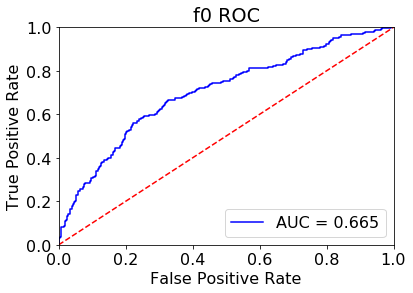

In [76]:
roc_plot(f0, X_0, Y_0, title='f0 ROC')

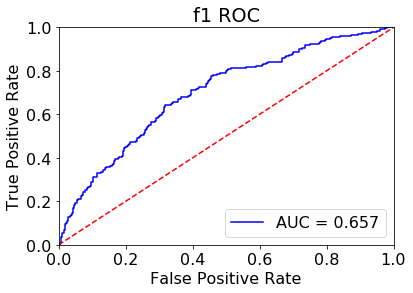

In [77]:
roc_plot(f1, X_1, Y_1, title='f1 ROC')

In [99]:
A_1 = data[(data['Y'] == 1) & (data['T'] == 1)].shape[0]
B_1_hat = (f0.predict(data[(data['Y'] == 1) & (data['T'] == 1)].drop(['Y', 'T'], axis = 1))).sum()
C_1 = data[(data['Y'] == 0) & (data['T'] == 1)].shape[0]
D_1_hat = (1-f0.predict(data[(data['Y'] == 0) & (data['T'] == 1)].drop(['Y', 'T'], axis = 1))).sum()

A_0_hat = (f1.predict(data[(data['Y'] == 1) & (data['T'] == 0)].drop(['Y', 'T'], axis = 1))).sum()
B_0 = data[(data['Y'] == 1) & (data['T'] == 0)].shape[0]
C_0_hat = (1-f1.predict(data[(data['Y'] == 0) & (data['T'] == 0)].drop(['Y', 'T'], axis = 1))).sum()
D_0 = data[(data['Y'] == 0) & (data['T'] == 0)].shape[0]

print(A_1, B_1_hat)
print(C_1, D_1_hat)

print(A_0_hat, B_0)
print(C_0_hat, D_0)

a = float(A_1+B_1_hat)
d = float(C_0_hat+D_0)
c = float(C_1+D_1_hat)
b = float(A_0_hat+B_0)
odds_ratio_ci((a,b,c,d))

207 60
1178 1009
179 220
334 889


(0.374210560695291,
 (0.3156954949847625, 0.44357156171215867),
 (267.0, 399.0, 2187.0, 1223.0))